#  Algorithm training, testing, and validation

In the first 2 parts of our project we extracted solar radiation data for Boulogne-Billancourt (Greater Paris, France), cleaned the data and formated our data, then visualized our data in order to get some insights.
In this new section of our project, we are going to predict daily solar radiations in Boulogne - Billancour using the variables contained in our dataset.

## I- Import libraries and dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (16, 12)

In [2]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/solarcast_df_clean281221.csv")

In [3]:
# Display column names
df.columns

Index(['Unnamed: 0', 'MonthPE', 'Date', 'Season', 'Daily_Temp', 'Daily_Precip',
       'Daily_Humidity', 'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed',
       'Daily_DNI', 'Daily_GHI', 'Daily_radiation'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       1087 non-null   object 
 1   MonthPE          1087 non-null   int64  
 2   Date             1087 non-null   object 
 3   Season           1087 non-null   object 
 4   Daily_Temp       1087 non-null   float64
 5   Daily_Precip     1087 non-null   float64
 6   Daily_Humidity   1087 non-null   float64
 7   Daily_Pressure   1087 non-null   float64
 8   Daily_WindDir    1087 non-null   float64
 9   Daily_WindSpeed  1087 non-null   float64
 10  Daily_DNI        1087 non-null   float64
 11  Daily_GHI        1087 non-null   float64
 12  Daily_radiation  1087 non-null   float64
dtypes: float64(9), int64(1), object(3)
memory usage: 110.5+ KB


In [5]:
# Feature Engineering of Time Series Column
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [6]:
# Display column names
df.columns

Index(['Unnamed: 0', 'MonthPE', 'Date', 'Season', 'Daily_Temp', 'Daily_Precip',
       'Daily_Humidity', 'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed',
       'Daily_DNI', 'Daily_GHI', 'Daily_radiation', 'year', 'month', 'day'],
      dtype='object')

In [7]:
# Select features to be used for modelling
df = df[['month', 'day','Daily_Temp', 'Daily_Precip', 'Daily_Humidity',
       'Daily_Pressure', 'Daily_WindDir', 'Daily_WindSpeed', 'Daily_DNI',
       'Daily_GHI', 'Daily_radiation']]
df.head()

,month,day,Daily_Temp,Daily_Precip,Daily_Humidity,Daily_Pressure,Daily_WindDir,Daily_WindSpeed,Daily_DNI,Daily_GHI,Daily_radiation
0,12,31,7.855556,13.611111,95.111111,1020.955556,329.777778,1.844444,0.000000,34.444444,34.444444
1,1,1,6.900000,9.833333,89.888889,1019.022222,307.888889,3.522222,0.000000,35.888889,35.888889
2,1,2,4.266667,6.800000,73.666667,1024.233333,12.222222,4.600000,10.444444,67.000000,66.222222
3,1,3,2.800000,7.600000,83.222222,1024.522222,22.666667,3.233333,22.111111,83.666667,81.777778
4,1,4,2.011111,8.522222,86.222222,1024.433333,15.222222,3.077778,33.777778,65.222222,58.222222


## II- Model training and testing

### a) Model training

In [8]:
# produces a 70%, 15%, 15% split for training, validation and test sets
train_data, validation_data, test_data = np.split(df.sample(frac = 1), [int(.7 * len(df)), int(.85 * len(df))])

In [9]:
# Convert dataframes to .csv and save locally
train_data.to_csv('/content/solarcast_train.csv', header = True, index = False)
validation_data.to_csv('/content/solarcast_validation.csv', header=True, index = False)
test_data.to_csv('/content/solarcast_test.csv', header = True, index = False)

In [10]:
# Training data
train_df = pd.read_csv('/content/solarcast_train.csv')
X_train = train_df.drop(['Daily_radiation'], axis = 1)
y_train = train_df['Daily_radiation']

# Test data
test_df = pd.read_csv('/content/solarcast_test.csv')
X_test = test_df.drop(['Daily_radiation'], axis = 1)
y_test = test_df['Daily_radiation']

In [11]:
# Create a pipeline to scale our data then fit our different models
pipelines = {
    'LR': make_pipeline(StandardScaler(), LinearRegression()),
    'RFC': make_pipeline(StandardScaler(), RandomForestRegressor(random_state=1)),
    'XGB': make_pipeline(StandardScaler(), xgb.XGBRegressor(objective ='reg:squarederror', random_state=1)),
    'CART': make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=1)),
    'LGB': make_pipeline(StandardScaler(),lgb.LGBMRegressor(random_state=1))
}

In [12]:
# Check the content of our pipeline dictionary
pipelines.items()

dict_items([('LR', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])), ('RFC', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=1))])), ('XGB', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(objective='reg:squarederror', random_state=1))])), ('CART', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1))])), ('LGB', Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor(random_state=1))]))])

In [13]:
# The following code fits the model, and evoluate model performance
# through cross validation in order to see how models generalize
fitted_models ={}
results = []
names = []
for name, model in pipelines.items():
    # Fit model on X_train, y_train
    model.fit(X_train, y_train)
    # Store model in fitted_models[name] for later use
    fitted_models[name] = model
    # Print '{name} has been fitted'
    print(name, 'has been fitted.')

    # Cross validation in order to see how the model generalizes across 10 foldS
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)#
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    # Print average r2 and standard deviation of r2 based on 10 CV folds
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR has been fitted.
LR: 0.811709 (0.021050)
RFC has been fitted.
RFC: 0.957864 (0.009064)
XGB has been fitted.
XGB: 0.954373 (0.009379)
CART has been fitted.
CART: 0.924584 (0.019041)
LGB has been fitted.
LGB: 0.964086 (0.008578)


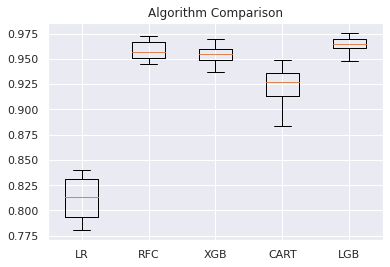

In [14]:
# Visualize performace of each model using boxplots
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Among our 5 models, LightGBM is the one performing better in terms of average R2 score on the 10 folds. This model is also the one that generalizes better as shown by the CV r2 standard deviation in parenthesis.

### b) Evaluating model on test set

Now we wil evaluate the model performance of our 5 models using the test set. We will make predictions on the test and compare our predictions vs actual values.

***Linear Regression***

In [15]:
fitted_models['LR']

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [16]:
# Make prediction on the test set
y_pred_lr = fitted_models['LR'].predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr, squared = False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print('Linear Regression model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_lr))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lr))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lr))

Linear Regression model performance - test set
r2_score:  0.8017358190413738
Root Mean Squared Error: 5.12
Root Mean Absolute Error: 4.65


Now let's visualize model prediction residuals ie true value - predicted value.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


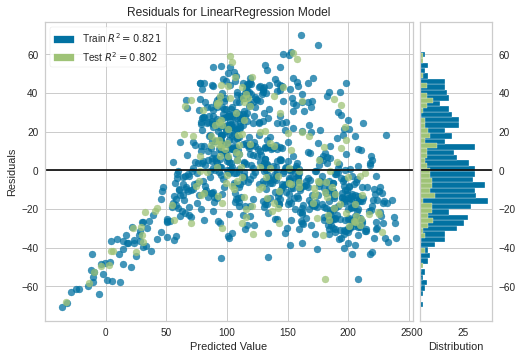

In [17]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(fitted_models['LR'])

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show()                

Looking at the graph above, we notice a long tail for which residuals are between -20 and - 70, and predicted values inferior to 50.
When performing data visualization in our previous notebook, we noticed that the relationships between Daily radiations and other features were not linear. This probably explains the poor performance we see here on some of the data points.

Now we will visualize predictions vs actual target values.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


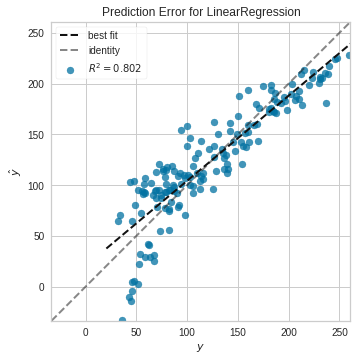

In [18]:
from yellowbrick.regressor import PredictionError

visualizer2 = PredictionError(fitted_models['LR'])
visualizer2.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer2.score(X_test, y_test)  # Evaluate the model on the test data
visualizer2.show()                 # Finalize and render the figure

The model regression line is quite far off the identify line ie the line where predictions = actual values.

***Random Forest***

In [19]:
# Make prediction on the test set
y_pred_rfc = fitted_models['RFC'].predict(X_test)

mse_rfc = mean_squared_error(y_test, y_pred_rfc, squared = False)
mae_rfc = mean_absolute_error(y_test, y_pred_rfc)

print('RandomForest model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_rfc))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_rfc))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_rfc))

RandomForest model performance - test set
r2_score:  0.9623612942843829
Root Mean Squared Error: 3.38
Root Mean Absolute Error: 2.90


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


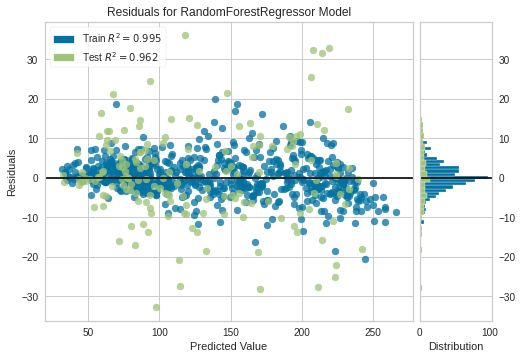

In [20]:
visualizer3 = ResidualsPlot(fitted_models['RFC'])

visualizer3.fit(X_train, y_train)  
visualizer3.score(X_test, y_test)  
visualizer3.show()                 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


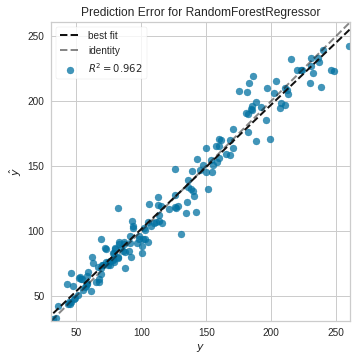

In [21]:
visualizer4 = PredictionError(fitted_models['RFC'])
visualizer4.fit(X_train, y_train)  
visualizer4.score(X_test, y_test)  
visualizer4.show()                 

Here we see a net improvement of model performance vs Linear Regression model performance.


***XGBoost***

In [22]:
# Make prediction on the test set
y_pred_xgb = fitted_models['XGB'].predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared = False)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print('XGBoosr model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_xgb))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_xgb))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_xgb))

XGBoosr model performance - test set
r2_score:  0.9536524912754675
Root Mean Squared Error: 3.56
Root Mean Absolute Error: 3.10


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


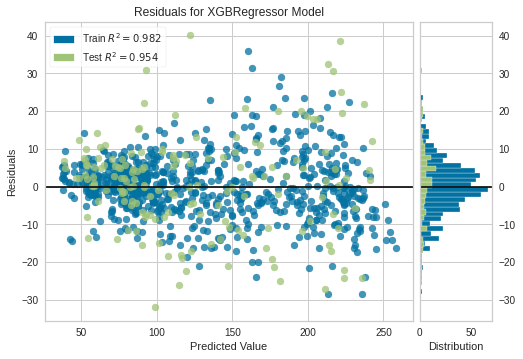

In [23]:
visualizer5 = ResidualsPlot(fitted_models['XGB'])

visualizer5.fit(X_train, y_train)  
visualizer5.score(X_test, y_test)  
visualizer5.show()                 

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


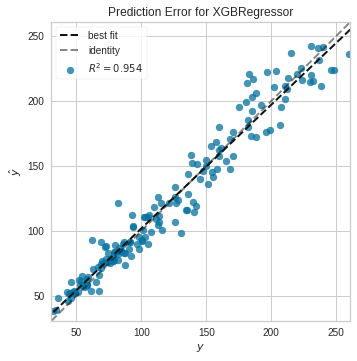

In [24]:
visualizer6 = PredictionError(fitted_models['XGB'])
visualizer6.fit(X_train, y_train)
visualizer6.score(X_test, y_test) 
visualizer6.show()                 

***Light GBM***

In [25]:
# Make prediction on the test set
y_pred_lgb = fitted_models['LGB'].predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred_lgb, squared = False)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)

print('LightGBM model performance - test set')
print('r2_score: ', r2_score(y_test, y_pred_lgb))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lgb))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lgb))

LightGBM model performance - test set
r2_score:  0.9688297224703545
Root Mean Squared Error: 3.22
Root Mean Absolute Error: 2.77


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


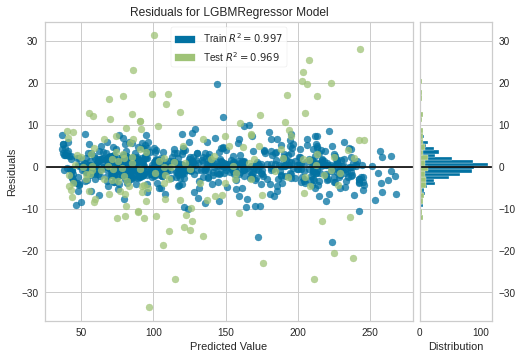

In [26]:
visualizer7 = ResidualsPlot(fitted_models['LGB'])

visualizer7.fit(X_train, y_train)  
visualizer7.score(X_test, y_test)  
visualizer7.show()                

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


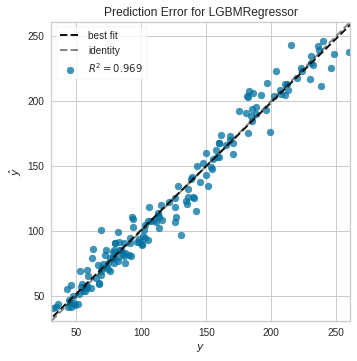

In [27]:
visualizer8 = PredictionError(fitted_models['LGB'])
visualizer8.fit(X_train, y_train)  
visualizer8.score(X_test, y_test)  
visualizer8.show()                 

We reach an equally good performance with XGBoost, LightGBM, RandomForestRegressor. Out of the 3 models, LightGBM is the one performing better.

### c) Validating model on validation set

Now we will make predictions using the validation set in order to validate our model. We will only use the following models in the validation part:
- Linear Regression model for explainability (despite its poorer model performance)
- LightGBM model as it is the best performing model

In [28]:
# Import validation data, and split target andfeature variables
val_df = pd.read_csv('/content/solarcast_train.csv')
X_val = val_df.drop(['Daily_radiation'], axis=1)
y_val = val_df['Daily_radiation']

In [29]:
y_val_lr = fitted_models['LR'].predict(X_val)
y_val_lgb = fitted_models['LGB'].predict(X_val)

In [30]:
# Evaluating algorithm performance for linear regression
mse_lr_val = mean_squared_error(y_val, y_val_lr, squared = False)

mae_lr_val = mean_absolute_error(y_val, y_val_lr)

print('Linear Regression model performance - validation set')
print('r2_score: ', r2_score(y_val, y_val_lr))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lr_val))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lr_val))

Linear Regression model performance - validation set
r2_score:  0.820953398783919
Root Mean Squared Error: 5.06
Root Mean Absolute Error: 4.58


In [31]:
# Evaluating algorithm performance for LightGBM model
mse_lgb_val = mean_squared_error(y_val, y_val_lgb, squared = False)

mae_lgb_val = mean_absolute_error(y_val, y_val_lgb)

print('LightGBM  model performance - validation set')
print('r2_score: ', r2_score(y_val, y_val_lgb))
print('Root Mean Squared Error: %.2f' % np.sqrt(mse_lgb_val))
print('Root Mean Absolute Error: %.2f' % np.sqrt(mae_lgb_val))

LightGBM  model performance - validation set
r2_score:  0.997156461878973
Root Mean Squared Error: 1.80
Root Mean Absolute Error: 1.51


Model performance improves on the validation set for both the Linear Regression model and the Light GBM model. For the LightGBM model, we almost reach perfect predictions with a R2 = 0.9973
The performance on the validation allow us to validate our LightGBM model.

Model performmance of our LightGBM could be improved by:
- performing hyperparameter tuning
- performing feature selection
- withdrawinb data points with higher prediction residuals

### d) Feature importance/ Model coefficients

Now, we will try to understand which features impact mostly daily radiation in both our models.

***Linear Regression***

In [32]:
coef_table = pd.DataFrame(fitted_models['LR']['linearregression'].coef_, index=X_train.columns)
coef_table.rename(columns={0: 'Coefficient'}, inplace=True)
coef_table.sort_values(by='Coefficient', ascending=False)

,Coefficient
Daily_GHI,86.306304
Daily_WindDir,7.734599
Daily_Precip,6.950556
Daily_Pressure,2.843838
day,0.926191
month,0.825156
Daily_WindSpeed,-2.646677
Daily_Humidity,-10.579227
Daily_Temp,-17.203564
Daily_DNI,-81.108194


Top contributing features are Daily GHI, Daily GNI and temperatures. It makes sense that Daily DNI and Daily GHI are the variables contributing most to model performance as they are used in the formula to calculate solar radiations level.

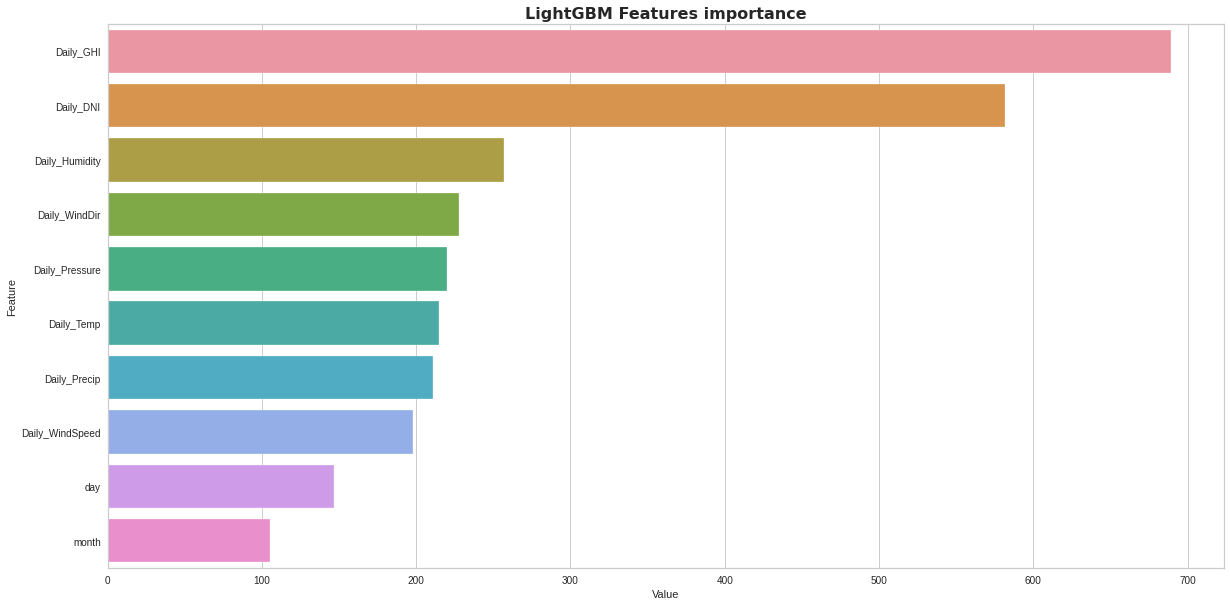

In [33]:
feature_imp = pd.DataFrame(sorted(zip(fitted_models['LGB']['lgbmregressor'].feature_importances_, 
                                      X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features importance',fontname="DejaVu Sans", size=16,fontweight="bold")

plt.show();
#plt.savefig('lgb_importances.png')

Here the most impactful features are also **Daily_GNI** and **Daily DHI**. However as variable #3, there is **Daily precipitation**.